<a href="https://colab.research.google.com/github/TillVollmer5/mass_spectroscopy/blob/main/Qualitative_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import pandas as pd
import seaborn as sns
from scipy.stats import norm, expon, gamma
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
Auto_1_pm_df = pd.read_csv('/content/drive/My Drive/Qualitative_Tracefinder_Data_2/Car_14_total_Auto1_PF_120k_125.csv')
Auto_1_gp_df = pd.read_csv('/content/drive/My Drive/Qualitative_Tracefinder_Data_2/Car_14_total_Auto1_PUF_hc_120k_138.csv')
Auto_2_gp_df = pd.read_csv('/content/drive/My Drive/Qualitative_Tracefinder_Data_2/Car_14_total_Auto2_PF_120k_147.csv')
Auto_2_pm_df = pd.read_csv('/content/drive/My Drive/Qualitative_Tracefinder_Data_2/Car_14_total_Auto2_PUF_120k_149.csv')
Auto_3_gp_df = pd.read_csv('/content/drive/My Drive/Qualitative_Tracefinder_Data_2/Car_14_total_Auto3_PUF_120k_165.csv')
Auto_3_pm_df = pd.read_csv('/content/drive/My Drive/Qualitative_Tracefinder_Data_2/Car_14_total_Auto3_PF_120k_170.csv')
QC_df = pd.read_csv('/content/drive/My Drive/Qualitative_Tracefinder_Data_2/Car_14_total_QC_Solvent_95_5_120k_169.csv')

In [3]:
Auto_1_pm_df['Ion Type'] = 'pm'
Auto_1_gp_df['Ion Type'] = 'gp'
Auto_2_gp_df['Ion Type'] = 'gp'
Auto_2_pm_df['Ion Type'] = 'pm'
Auto_3_gp_df['Ion Type'] = 'gp'
Auto_3_pm_df['Ion Type'] = 'pm'

Auto_1_pm_df['Sample Name'] = 'Auto_1'
Auto_1_gp_df['Sample Name'] = 'Auto_1'
Auto_2_gp_df['Sample Name'] = 'Auto_2'
Auto_2_pm_df['Sample Name'] = 'Auto_2'
Auto_3_gp_df['Sample Name'] = 'Auto_3'
Auto_3_pm_df['Sample Name'] = 'Auto_3'

In [4]:
def drop_nan_rows(dataframe):
    """
    Drop rows where the elemental composition is NaN.

    Parameters:
    dataframe (pd.DataFrame): Input DataFrame.

    Returns:
    pd.DataFrame: DataFrame with NaN rows removed.
    """
    return dataframe.dropna(subset=['Elemental Composition'])

def check_duplicate_rows(dataframe, retention_time_threshold=3, mass_threshold=10):
    """
    Check for duplicate rows based on retention time and monoisotopic mass.

    Parameters:
    dataframe (pd.DataFrame): Input DataFrame.
    retention_time_threshold (float): Retention time threshold in minutes.
    mass_threshold (float): Mass threshold.

    Returns:
    pd.DataFrame: DataFrame with duplicate rows removed.
    """

    # Define the conditions for considering rows as duplicates
    conditions = [(dataframe['Retention Time'].duplicated(keep=False) & ((dataframe['Retention Time'] - dataframe['Retention Time'].shift()).abs() <= retention_time_threshold) & (dataframe['M/Z'].duplicated(keep=False) & (dataframe['M/Z'] - dataframe['M/Z'].shift()).abs() <= mass_threshold))]

    dataframe = dataframe[~pd.concat(conditions, axis=1).any(axis=1)].copy()

    return dataframe

def qc_removal(auto_df, qc_df, retention_time_threshold=35, mass_threshold=10):
    """
    Compare each row in the Auto DataFrame with the corresponding retention time in the QC DataFrame.
    Drop the row if the retention time is within the threshold and the monoisotopic mass is the same.

    Parameters:
    auto_df (pd.DataFrame): Auto DataFrame.
    qc_df (pd.DataFrame): QC DataFrame.
    retention_time_threshold (float): Retention time threshold in minutes.
    mass_threshold (float): Mass threshold.

    Returns:
    pd.DataFrame: Updated Auto DataFrame with rows dropped based on QC criteria.
    """
    auto_df_copy = auto_df.copy()

    for index, auto_row in auto_df.iterrows():
        qc_row = qc_df[(qc_df['Retention Time'] - auto_row['Retention Time']).abs() <= retention_time_threshold]

        if not qc_row.empty:
            if abs(qc_row.iloc[0]['M/Z'] - auto_row['M/Z']) <= mass_threshold:
                auto_df_copy = auto_df_copy.drop(index)

    return auto_df_copy

def process_auto_dfs(auto_dfs, threshold=1):
    """
    Process a list of Auto DataFrames according to the specified criteria.

    Parameters:
    auto_dfs (list): List of Auto DataFrames.
    threshold (float): Retention time threshold for duplicates.

    Returns:
    pd.DataFrame: Processed DataFrame with comparison columns.
    """
    processed_df = pd.DataFrame()

    print("Step 1: Created an empty DataFrame.")
    print("Shape of Processed DataFrame:", processed_df.shape)

    for auto_df in auto_dfs:
        processed_df = processed_df.append(auto_df, ignore_index=True)

    print("\nStep 2-3: Appended rows from each Auto DataFrame.")
    print("Shape of Processed DataFrame after appending:", processed_df.shape)

    processed_df.drop_duplicates(subset=['Retention Time', 'Elemental Composition'], inplace=True)

    print("\nStep 4: Dropped duplicates based on retention time and elemental composition.")
    print("Shape of Processed DataFrame after dropping duplicates:", processed_df.shape)

    processed_df.sort_values(by='Retention Time', inplace=True)

    print("\nStep 5: Sorted DataFrame based on retention time.")
    print("Shape of Processed DataFrame after sorting:", processed_df.shape)

    for i, auto_df in enumerate(auto_dfs, start=1):
        col_name = f'Match_{i}'
        processed_df[col_name] = False

        print(f"\nStep 7: Created '{col_name}' column with False values.")
        print("Shape of Processed DataFrame after adding match column:", processed_df.shape)

        for index, row in processed_df.iterrows():
            match_condition = (abs(auto_df['Retention Time'] - row['Retention Time']) <= threshold) & (auto_df['Elemental Composition'] == row['Elemental Composition'])

            if match_condition.any():
                processed_df.at[index, col_name] = True

        print("\nStep 10: Updated match columns.")
        print("Shape of Processed DataFrame after updating match columns:", processed_df.shape)

    print("\nFinal Processed DataFrame:")
    print("Shape of Processed DataFrame:", processed_df.shape)

    return processed_df

def sum_matches(df):
    # Create a new column to store the sum of True values
    df['Sum_of_Matches'] = df.filter(like='Match').sum(axis=1)

    return df

In [5]:
Auto_1_pm_df = drop_nan_rows(Auto_1_pm_df)
Auto_1_pm_df = check_duplicate_rows(Auto_1_pm_df)

Auto_1_gp_df = drop_nan_rows(Auto_1_gp_df)
Auto_1_gp_df = check_duplicate_rows(Auto_1_gp_df)

Auto_2_gp_df = drop_nan_rows(Auto_2_gp_df)
Auto_2_gp_df = check_duplicate_rows(Auto_2_gp_df)

Auto_2_pm_df = drop_nan_rows(Auto_2_pm_df)
Auto_2_pm_df = check_duplicate_rows(Auto_2_pm_df)

Auto_3_gp_df = drop_nan_rows(Auto_3_gp_df)
Auto_3_gp_df = check_duplicate_rows(Auto_3_gp_df)

Auto_3_pm_df = drop_nan_rows(Auto_3_pm_df)
Auto_3_pm_df = check_duplicate_rows(Auto_3_pm_df)

QC_df = drop_nan_rows(QC_df)
QC_df = check_duplicate_rows(QC_df)

print(len(Auto_1_gp_df['Retention Time']))
print(len(Auto_1_pm_df['Retention Time']))
print(len(Auto_2_gp_df['Retention Time']))
print(len(Auto_2_pm_df['Retention Time']))
print(len(Auto_3_gp_df['Retention Time']))
print(len(Auto_3_pm_df['Retention Time']))
print(len(QC_df['Retention Time']))

199
294
276
223
224
268
226


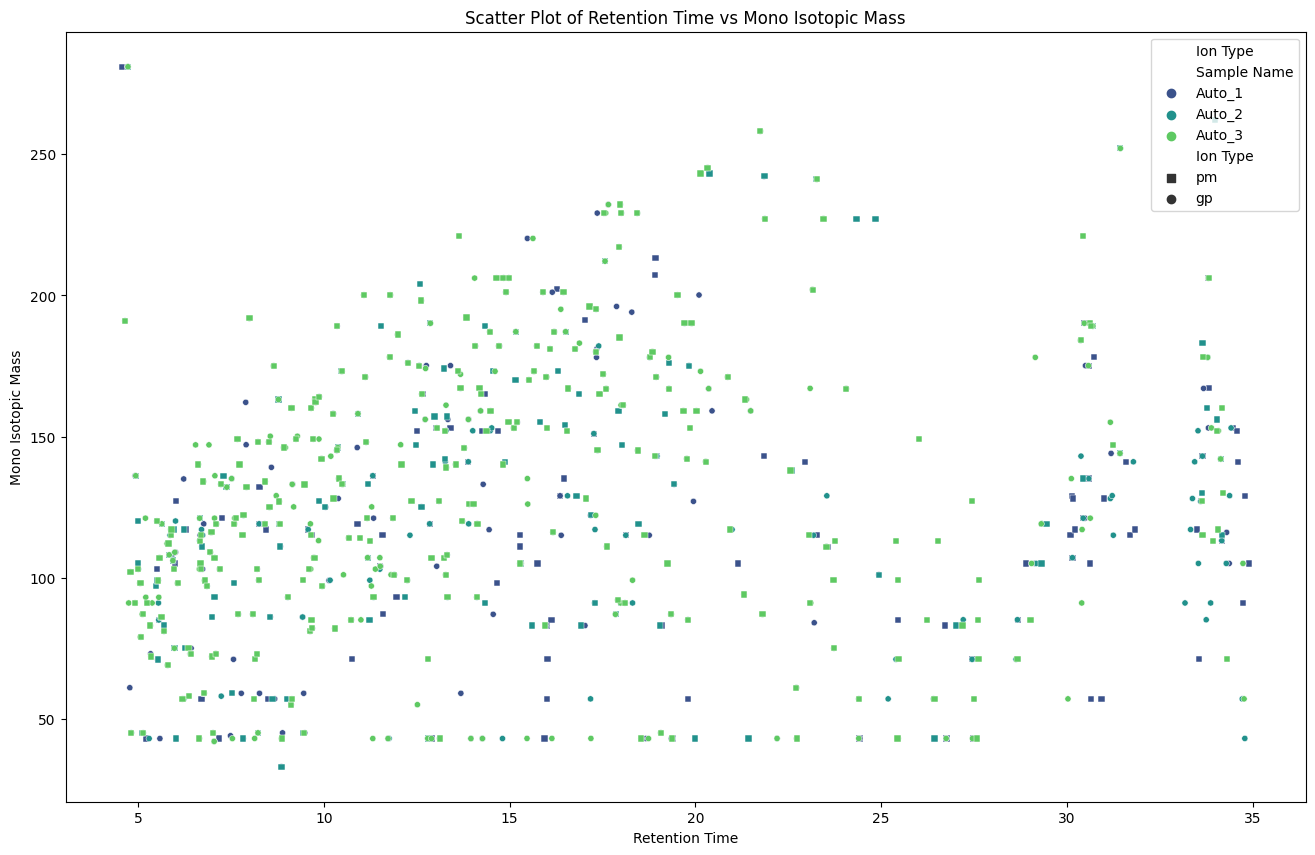

In [6]:
all_dfs = pd.concat([Auto_1_pm_df, Auto_1_gp_df, Auto_2_gp_df, Auto_2_pm_df, Auto_3_gp_df, Auto_3_pm_df])

# Define a dictionary to map 'Ion Type' to shapes
ion_type_shapes = {'gp': 'o', 'pm': 's'}

# Create a scatter plot
plt.figure(figsize=(16, 10))
sns.scatterplot(data=all_dfs, x='Retention Time', y='M/Z', hue='Sample Name', style='Ion Type', markers=ion_type_shapes, palette='viridis', s=20)

# Add labels and title
plt.xlabel('Retention Time')
plt.ylabel('Mono Isotopic Mass')
plt.title('Scatter Plot of Retention Time vs Mono Isotopic Mass')

# Display the legend
plt.legend(title='Ion Type')

# Show the plot
plt.show()

In [7]:
Auto_1_pm_df_f = qc_removal(Auto_1_pm_df, QC_df)
Auto_1_gp_df_f = qc_removal(Auto_1_gp_df, QC_df)
Auto_2_gp_df_f = qc_removal(Auto_2_gp_df, QC_df)
Auto_2_pm_df_f = qc_removal(Auto_2_pm_df, QC_df)
Auto_3_gp_df_f = qc_removal(Auto_3_gp_df, QC_df)
Auto_3_pm_df_f = qc_removal(Auto_3_pm_df, QC_df)

print(len(Auto_1_gp_df_f['Retention Time']))
print(len(Auto_1_gp_df['Retention Time']))
print(len(Auto_2_gp_df_f['Retention Time']))
print(len(Auto_2_gp_df['Retention Time']))
print(len(Auto_3_gp_df_f['Retention Time']))
print(len(Auto_3_gp_df['Retention Time']))
print(len(Auto_1_pm_df_f['Retention Time']))
print(len(Auto_1_pm_df['Retention Time']))
print(len(Auto_2_pm_df_f['Retention Time']))
print(len(Auto_2_pm_df['Retention Time']))
print(len(Auto_3_pm_df_f['Retention Time']))
print(len(Auto_3_pm_df['Retention Time']))

187
199
258
276
201
224
276
294
210
223
254
268


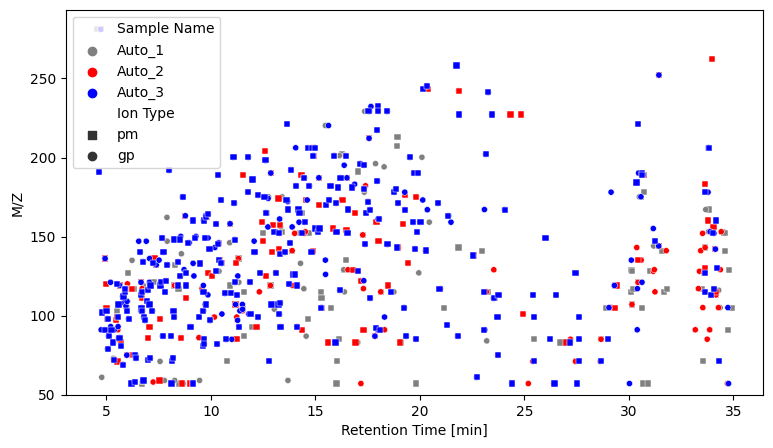

In [ ]:
all_dfs_f = pd.concat([Auto_1_pm_df_f, Auto_1_gp_df_f, Auto_2_gp_df_f, Auto_2_pm_df_f, Auto_3_gp_df_f, Auto_3_pm_df_f])
all_dfs_f['Carbon Number'] = all_dfs_f['Elemental Composition'].str.extract(r'C(\d+)').astype(float)
# Define a dictionary to map 'Ion Type' to shapes
ion_type_shapes = {'gp': 'o', 'pm': 's'}

# Create a scatter plot
plt.figure(figsize=(9, 5))
sns.scatterplot(data=all_dfs_f, x='Retention Time', y='M/Z', hue='Sample Name', style='Ion Type', markers=ion_type_shapes, palette={'red', 'blue', 'gray'}, s=20)

# Add labels and title
plt.xlabel('Retention Time [min]')
plt.ylabel('M/Z')
plt.ylim(bottom=50)
# Display the legend
plt.legend(title='')
plt.savefig('/content/drive/My Drive/Plot_TF_mz_scatter.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

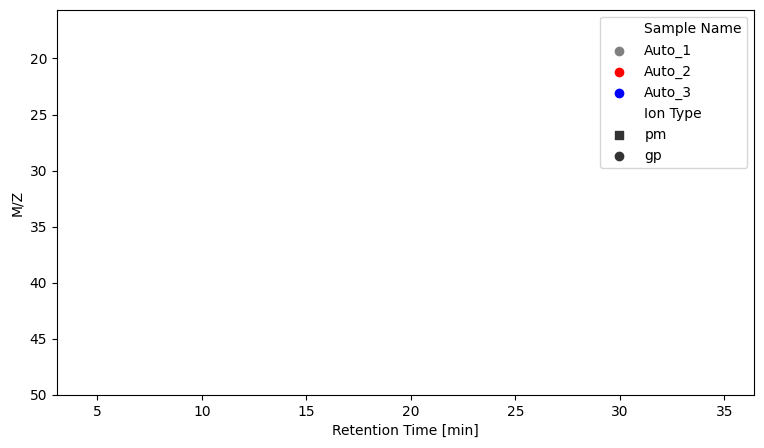

In [ ]:
plt.figure(figsize=(9, 5))
sns.scatterplot(data=all_dfs_f, x='Retention Time', y='Carbon Number', hue='Sample Name', style='Ion Type', markers=ion_type_shapes, palette={'red', 'blue', 'gray'}, s=20)

# Add labels and title
plt.xlabel('Retention Time [min]')
plt.ylabel('M/Z')
plt.ylim(bottom=50)
# Display the legend
plt.legend(title='')
plt.savefig('/content/drive/My Drive/Plot_TF_Cnumber_scatter.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

In [8]:
auto_dfs = [Auto_1_pm_df_f, Auto_1_gp_df_f, Auto_2_gp_df_f, Auto_2_pm_df_f, Auto_3_gp_df_f, Auto_3_pm_df_f]

# Call the process_auto_dfs function
processed_df = process_auto_dfs(auto_dfs)

# Print the processed DataFrame
print(processed_df)

# Check the columns to see if the new match columns are present
print(processed_df.columns)

print(processed_df.head())

Step 1: Created an empty DataFrame.
Shape of Processed DataFrame: (0, 0)

Step 2-3: Appended rows from each Auto DataFrame.
Shape of Processed DataFrame after appending: (1386, 28)

Step 4: Dropped duplicates based on retention time and elemental composition.
Shape of Processed DataFrame after dropping duplicates: (699, 28)

Step 5: Sorted DataFrame based on retention time.
Shape of Processed DataFrame after sorting: (699, 28)

Step 7: Created 'Match_1' column with False values.
Shape of Processed DataFrame after adding match column: (699, 29)


<ipython-input-4-630c351235cd>:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  processed_df = processed_df.append(auto_df, ignore_index=True)



Step 10: Updated match columns.
Shape of Processed DataFrame after updating match columns: (699, 29)

Step 7: Created 'Match_2' column with False values.
Shape of Processed DataFrame after adding match column: (699, 30)

Step 10: Updated match columns.
Shape of Processed DataFrame after updating match columns: (699, 30)

Step 7: Created 'Match_3' column with False values.
Shape of Processed DataFrame after adding match column: (699, 31)

Step 10: Updated match columns.
Shape of Processed DataFrame after updating match columns: (699, 31)

Step 7: Created 'Match_4' column with False values.
Shape of Processed DataFrame after adding match column: (699, 32)

Step 10: Updated match columns.
Shape of Processed DataFrame after updating match columns: (699, 32)

Step 7: Created 'Match_5' column with False values.
Shape of Processed DataFrame after adding match column: (699, 33)

Step 10: Updated match columns.
Shape of Processed DataFrame after updating match columns: (699, 33)

Step 7: Creat

In [9]:
processed_df.to_csv('/content/drive/My Drive/processed_peaks.csv')

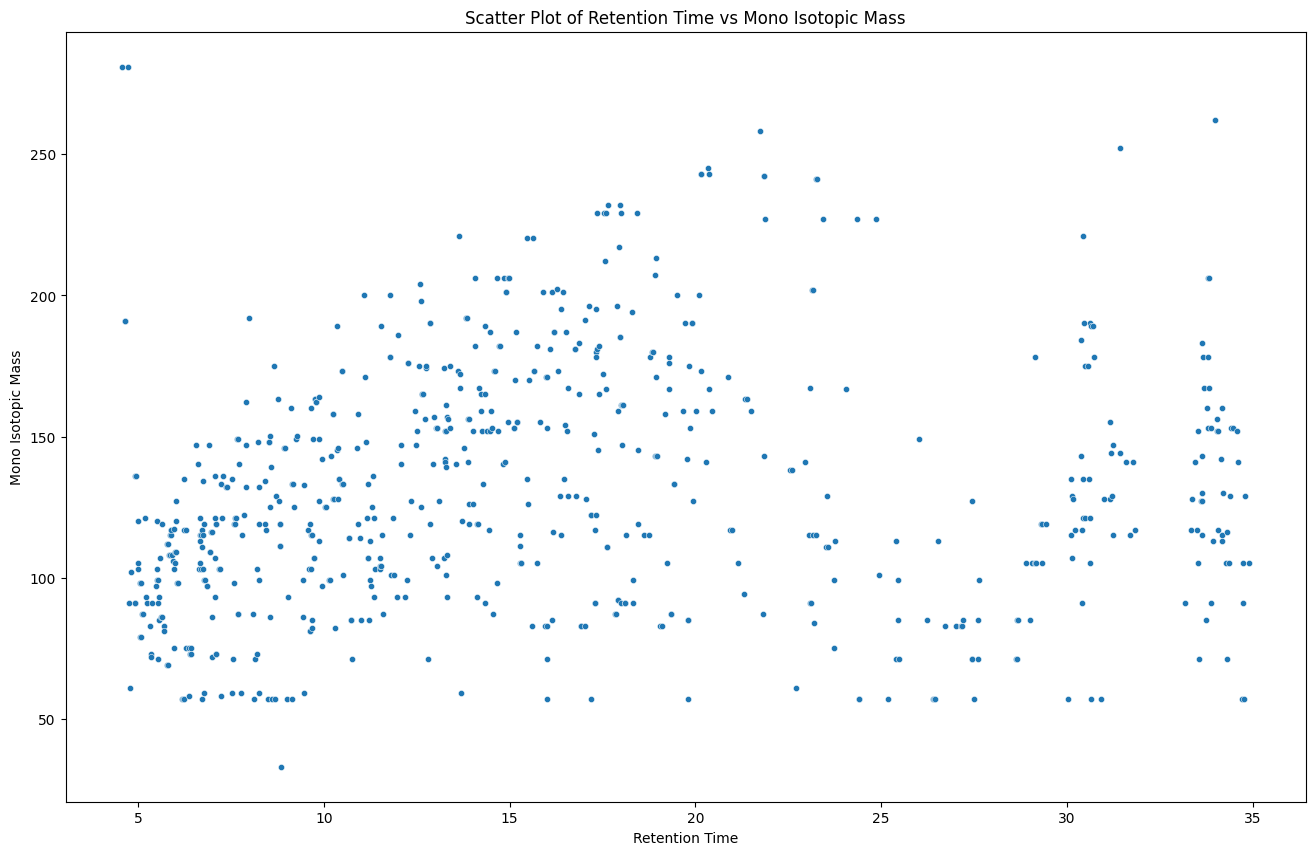

In [10]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=processed_df, x='Retention Time', y='M/Z', s=20)

# Add labels and title
plt.xlabel('Retention Time')
plt.ylabel('Mono Isotopic Mass')
plt.title('Scatter Plot of Retention Time vs Mono Isotopic Mass')


# Show the plot
plt.show()

In [11]:
processed_df_sum = sum_matches(processed_df)

print(processed_df_sum.head())

                 Peak ID         M/Z  Retention Time          Area  \
0     peak @ 4.79 281.05  281.051239            4.57  2.742177e+07   
463   peak @ 4.68 191.00  191.001038            4.65  3.446732e+07   
1132  peak @ 4.68 191.00  191.001007            4.66  4.125338e+07   
276   peak @ 5.02 281.05  281.051239            4.73  3.294000e+07   
932    peak @ 4.77 91.05   91.054276            4.75  2.399113e+08   

            Height  Potential ID        Mass  Mono Isotopic Mass  \
0     2.053193e+06             3  280.247955          280.043976   
463   1.705005e+06             3  190.158936          189.993759   
1132  9.716185e+05             3  190.158051          189.993729   
276   9.439935e+06             3  280.236847          280.043976   
932   2.532226e+07             1   90.046860           90.046997   

      Charge State                           Filter String  ... Fragments  \
0                1  FTMS + p EI Full ms [33.0000-600.0000]  ...       NaN   
463             

<ipython-input-4-630c351235cd>:113: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['Sum_of_Matches'] = df.filter(like='Match').sum(axis=1)


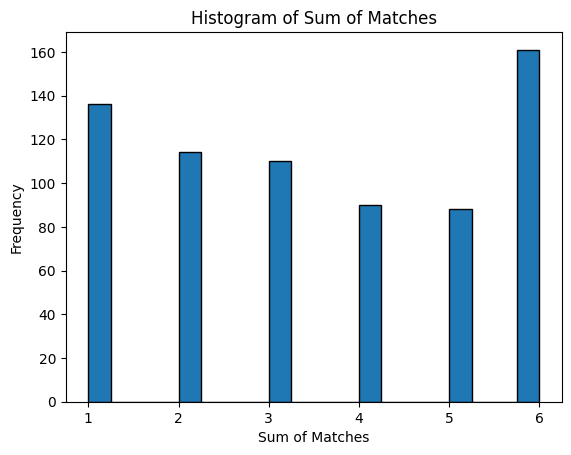

In [12]:
plt.hist(processed_df_sum['Sum_of_Matches'], bins=20, edgecolor='black')
plt.title('Histogram of Sum of Matches')
plt.xlabel('Sum of Matches')
plt.ylabel('Frequency')
plt.show()

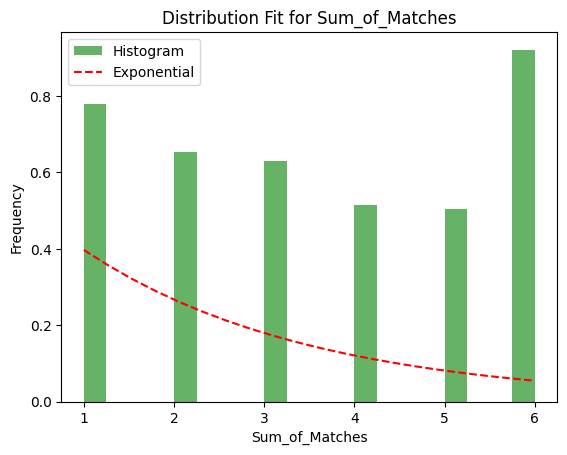

In [14]:
plt.hist(processed_df_sum['Sum_of_Matches'], bins=20, density=True, alpha=0.6, color='g', label='Histogram')

# Fit different distribution models
def fit_distribution(data, dist, bins=20, **kwargs):
    params = dist.fit(data)
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    x = np.linspace(min(data), max(data), bins)
    fitted_pdf = dist.pdf(x, loc=loc, scale=scale, *arg)
    plt.plot(x, fitted_pdf, **kwargs)

# Fit an exponential distribution
fit_distribution(processed_df_sum['Sum_of_Matches'], expon, color='r', linestyle='dashed', label='Exponential')


plt.title('Distribution Fit for Sum_of_Matches')
plt.xlabel('Sum_of_Matches')
plt.ylabel('Frequency')
plt.legend()
plt.show()

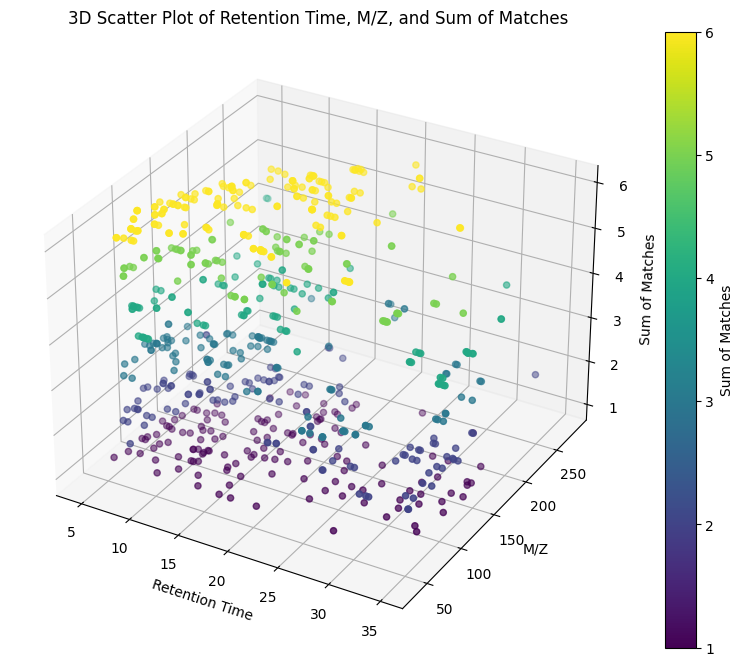

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(processed_df_sum['Retention Time'], processed_df_sum['M/Z'], processed_df_sum['Sum_of_Matches'], c=processed_df_sum['Sum_of_Matches'], cmap='viridis')

# Labeling axes
ax.set_xlabel('Retention Time')
ax.set_ylabel('M/Z')
ax.set_zlabel('Sum of Matches')

# Adding colorbar
cbar = fig.colorbar(scatter)
cbar.set_label('Sum of Matches')

plt.title('3D Scatter Plot of Retention Time, M/Z, and Sum of Matches')
plt.show()


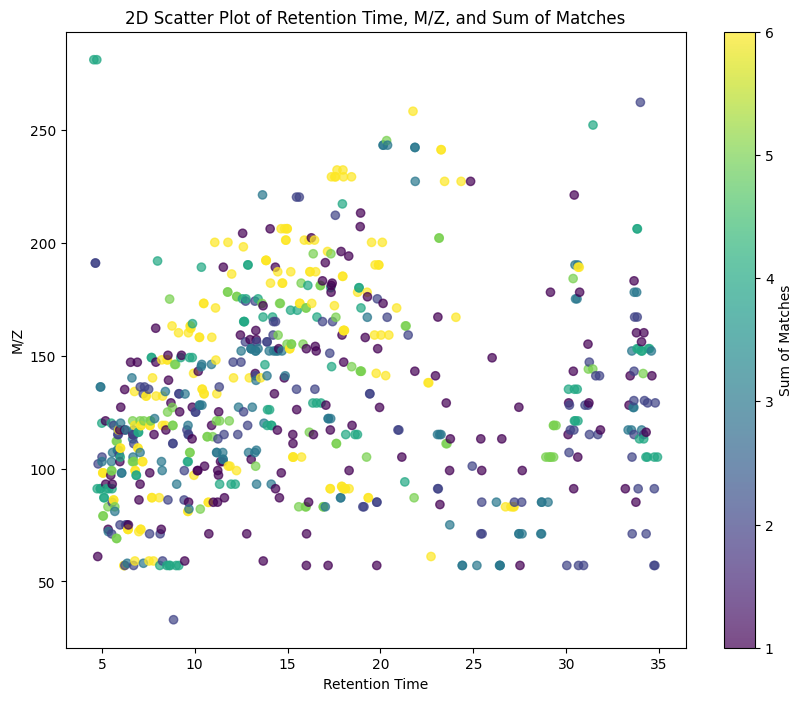

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(processed_df_sum['Retention Time'], processed_df_sum['M/Z'], c=processed_df_sum['Sum_of_Matches'], cmap='viridis', alpha=0.7)

# Labeling axes
plt.xlabel('Retention Time')
plt.ylabel('M/Z')

# Adding colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Sum of Matches')

plt.title('2D Scatter Plot of Retention Time, M/Z, and Sum of Matches')
plt.show()

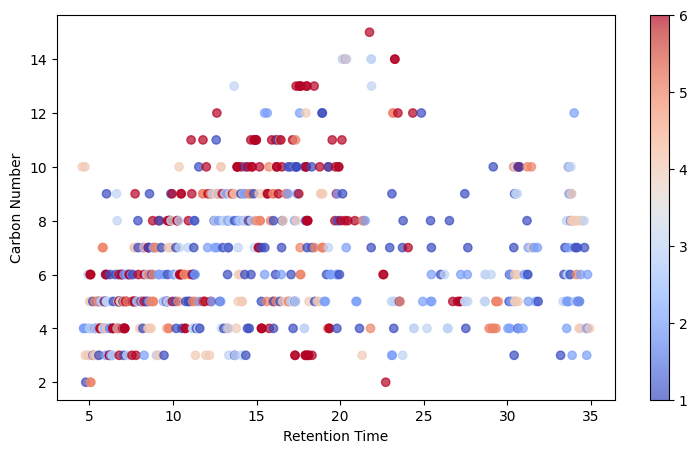

In [22]:
processed_df_sum['Carbon Number'] = processed_df_sum['Elemental Composition'].str.extract(r'C(\d+)').astype(float)

# Scatter plot
plt.figure(figsize=(9, 5))
scatter = plt.scatter(processed_df_sum['Retention Time'], processed_df_sum['Carbon Number'], c=processed_df_sum['Sum_of_Matches'], cmap='coolwarm', alpha=0.7)

# Labeling axes
plt.xlabel('Retention Time')
plt.ylabel('Carbon Number')

# Adding colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('')

plt.title('')
plt.savefig('/content/drive/My Drive/Plot_carbonnr_sum_of_matches.png', dpi=300, bbox_inches='tight')
plt.show()

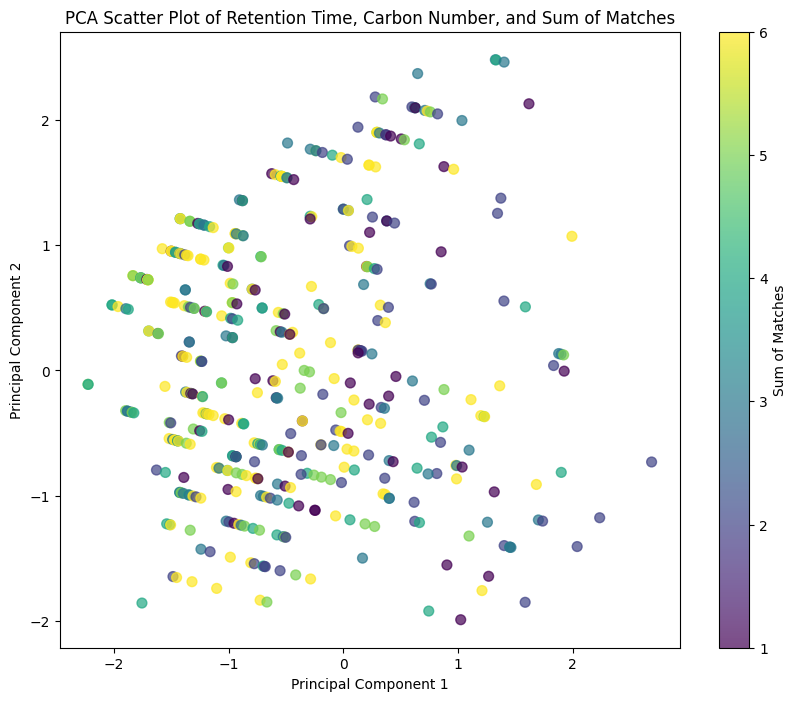

In [ ]:
columns_for_pca = ['Retention Time', 'Carbon Number', 'Sum_of_Matches']

# Handling missing values by imputing the mean (you can adjust this strategy)
imputer = SimpleImputer(strategy='mean')
processed_df_sum[columns_for_pca] = imputer.fit_transform(processed_df_sum[columns_for_pca])

# Standardizing the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(processed_df_sum[columns_for_pca])

# Performing PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Creating a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(scaled_data.shape[1])])

# Adding the 'Sum_of_Matches' column to the PCA DataFrame
pca_df['Sum_of_Matches'] = processed_df_sum['Sum_of_Matches']

# Plotting the PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Sum_of_Matches'], cmap='viridis', s=50, alpha=0.7)

# Labeling axes
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Adding colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Sum of Matches')

plt.title('PCA Scatter Plot of Retention Time, Carbon Number, and Sum of Matches')
plt.show()

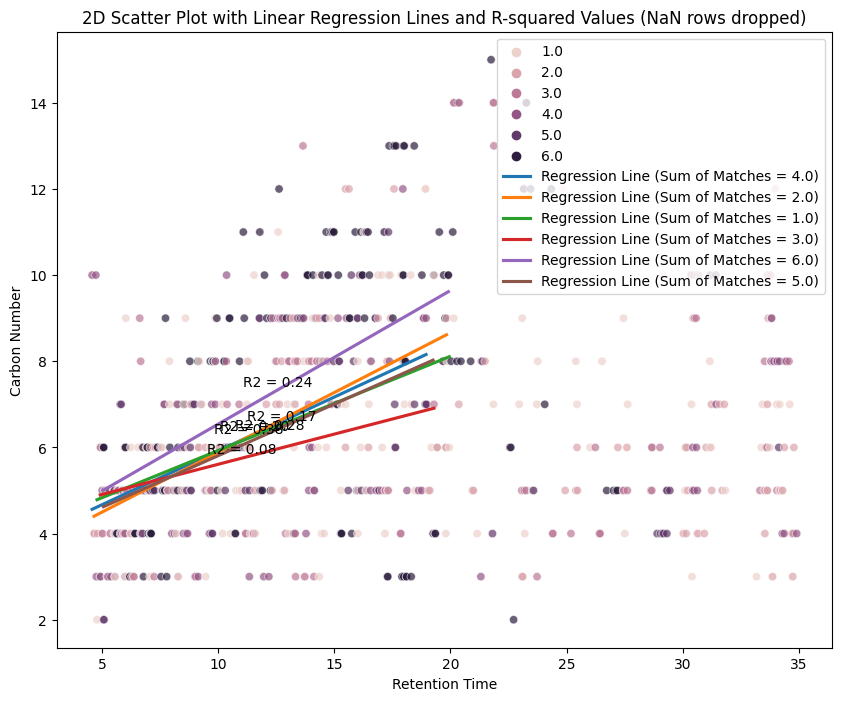

In [ ]:
processed_df_sum = processed_df_sum.dropna(subset=['Retention Time', 'Carbon Number', 'Sum_of_Matches']).copy()

# Extracting the number of carbon atoms from the 'Elemental Composition' column
processed_df_sum['Carbon Number'] = processed_df_sum['Elemental Composition'].str.extract(r'C(\d+)').astype(float)

# Define the time range for linear regression (e.g., the first 20 minutes)
time_range = (0, 20)

# Scatter plot
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x='Retention Time', y='Carbon Number', hue='Sum_of_Matches', data=processed_df_sum, alpha=0.7)

# Fit linear regression models and plot regression lines
for level in processed_df_sum['Sum_of_Matches'].unique():
    subset_df = processed_df_sum[(processed_df_sum['Sum_of_Matches'] == level) & (processed_df_sum['Retention Time'] >= time_range[0]) & (processed_df_sum['Retention Time'] <= time_range[1])]

    if not subset_df.empty:
        x = subset_df['Retention Time'].values.reshape(-1, 1)
        y = subset_df['Carbon Number'].values

        # Fit linear regression
        reg_model = LinearRegression().fit(x, y)

        # Predict values
        y_pred = reg_model.predict(x)

        # Plot regression line
        sns.regplot(x=subset_df['Retention Time'], y=y_pred, scatter=False, ax=plt.gca(), label=f'Regression Line (Sum of Matches = {level})')

        # Calculate R-squared
        r_squared = r2_score(y, y_pred)

        # Annotate the plot with R-squared value
        plt.annotate(f'R2 = {r_squared:.2f}', xy=(subset_df['Retention Time'].mean(), y_pred.mean()), textcoords='offset points', xytext=(5, 5), ha='center')

# Labeling axes
plt.xlabel('Retention Time')
plt.ylabel('Carbon Number')
# Show legend
plt.legend()

plt.title('2D Scatter Plot with Linear Regression Lines and R-squared Values (NaN rows dropped)')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


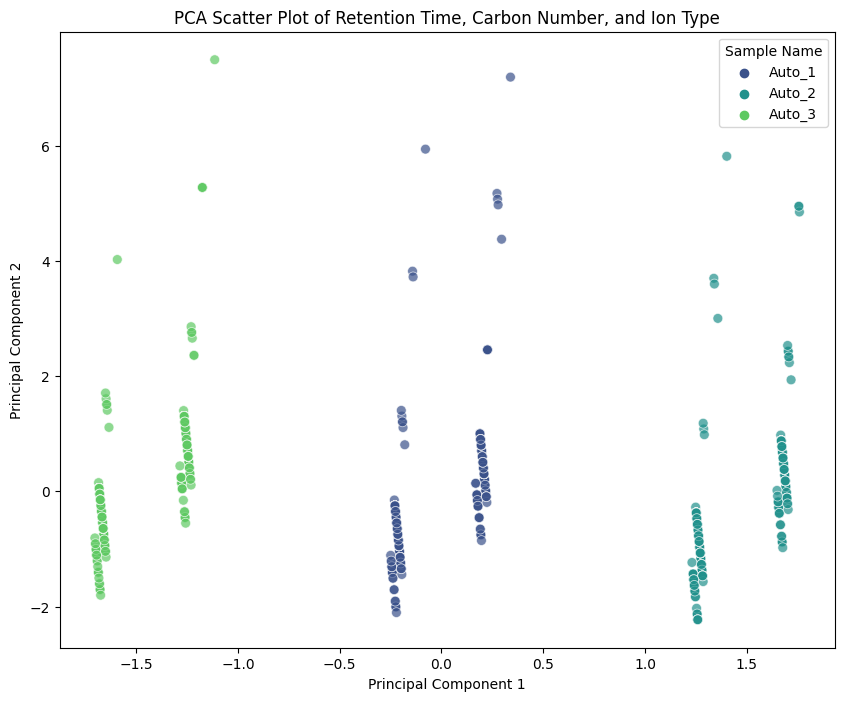

In [ ]:
all_dfs_f = pd.concat([Auto_1_pm_df_f, Auto_1_gp_df_f, Auto_2_gp_df_f, Auto_2_pm_df_f, Auto_3_gp_df_f, Auto_3_pm_df_f])
all_dfs_f['Carbon Number'] = all_dfs_f['Elemental Composition'].str.extract(r'C(\d+)').astype(float)
all_dfs_f['Oxygen Number'] = all_dfs_f['Elemental Composition'].str.extract(r'O(\d+)').astype(float)

numerical_columns = ['Carbon Number', 'Oxygen Number']

# Handling missing values by imputing the mean for numerical columns
imputer = SimpleImputer(strategy='mean')
all_dfs_f[numerical_columns] = imputer.fit_transform(all_dfs_f[numerical_columns])

# Extracting categorical column for encoding
categorical_column = ['Ion Type', 'Sample Name']

# Encoding categorical variables using one-hot encoding
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_categories = encoder.fit_transform(all_dfs_f[categorical_column])
encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(categorical_column))

# Resetting indices before concatenating
all_dfs_f.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# Concatenating numerical and encoded categorical columns
processed_df_final = pd.concat([all_dfs_f[numerical_columns], encoded_df], axis=1)

# Handling missing values by imputing the mean for the entire DataFrame
imputer_all = SimpleImputer(strategy='mean')
processed_df_final = pd.DataFrame(imputer_all.fit_transform(processed_df_final), columns=processed_df_final.columns)

# Standardizing the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(processed_df_final)

# Performing PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Creating a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(scaled_data.shape[1])])

# Plotting the PCA results with Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=all_dfs_f['Sample Name'], palette='viridis', s=50, alpha=0.7)

# Labeling axes
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.title('PCA Scatter Plot of Retention Time, Carbon Number, and Ion Type')
plt.show()

Loadings:
                         PC1       PC2       PC3       PC4       PC5
Carbon Number       0.007766 -0.272708  0.887945 -0.370302  0.000332
Oxygen Number       0.013556  0.716433  0.443923  0.537122 -0.031177
Ion Type_pm        -0.208447 -0.623610  0.116287  0.733615 -0.126285
Sample Name_Auto_2  0.700264 -0.058455 -0.011804  0.028793 -0.710805
Sample Name_Auto_3 -0.682595  0.141591 -0.028702 -0.188034 -0.691256


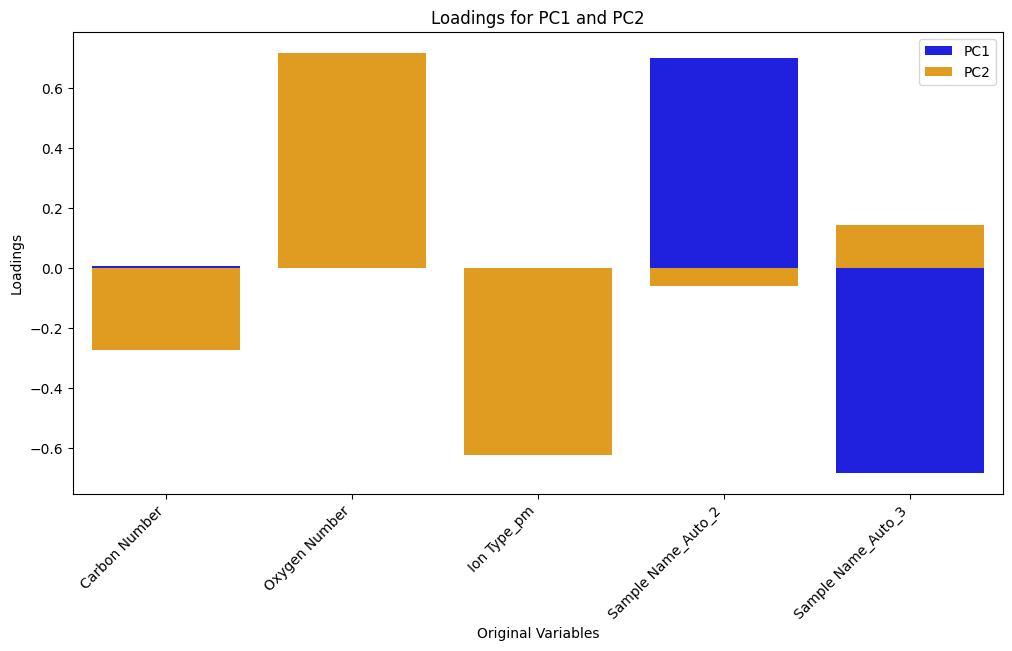

In [ ]:
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])], index=processed_df_final.columns)

# Display the loadings
print("Loadings:")
print(loadings)

# Plotting the loadings for PC1 and PC2
plt.figure(figsize=(12, 6))
sns.barplot(x=loadings.index, y=loadings['PC1'], color='blue', label='PC1')
sns.barplot(x=loadings.index, y=loadings['PC2'], color='orange', label='PC2')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Original Variables')
plt.ylabel('Loadings')
plt.title('Loadings for PC1 and PC2')
plt.legend()
plt.show()

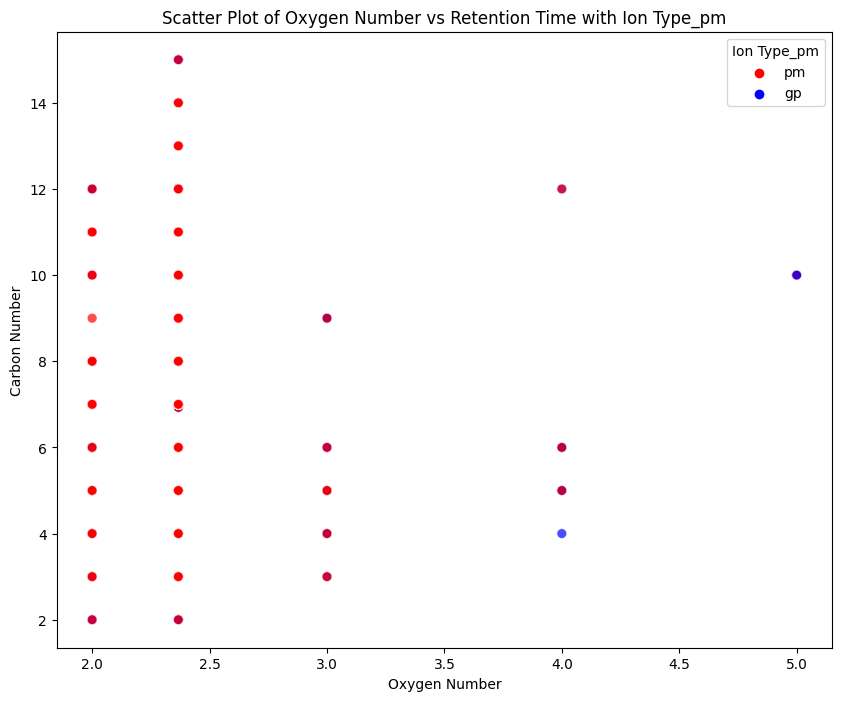

In [ ]:
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x='Oxygen Number', y='Carbon Number', hue='Ion Type', data=all_dfs_f, palette={'red', 'blue'}, s=50, alpha=0.7)

# Labeling axes
plt.xlabel('Oxygen Number')
plt.ylabel('Carbon Number')

# Adding a legend
plt.legend(title='Ion Type_pm')

# Adding a title
plt.title('Scatter Plot of Oxygen Number vs Retention Time with Ion Type_pm')

plt.show()